In [7]:
import cv2
import numpy as np
import pandas as pd
import os
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow.keras as K
import tensorflow.keras.backend as Kback
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf

# from google.colab import drive
# drive.mount('/content/drive')

# DCT

In [8]:
from scipy.fftpack import dct

def dct_2d(a):
    t = dct(dct(a.T).T)
    return t[0][0],t[0][1],t[1][0],t[2][0],t[0][2],t[2][2],t[0][4],t[4][0],t[3][2],t[2][3]

# Model Training

In [9]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = Kback.sum(Kback.round(Kback.clip(y_true * y_pred, 0, 1)))
    possible_positives = Kback.sum(Kback.round(Kback.clip(y_true, 0, 1)))
    predicted_positives = Kback.sum(Kback.round(Kback.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + Kback.epsilon())
    recall = true_positives / (possible_positives + Kback.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+Kback.epsilon())
    return f1_val

METRICS = [
      "accuracy",
      K.metrics.Precision(name='precision'),
      K.metrics.Recall(name='recall'),
      K.metrics.AUC(name='auc'),
      f1_score
]

# DenseNet121 all layers freezed

In [10]:
input_layer = K.Input(shape=(160,160,3))
resnet_model = K.applications.DenseNet121(include_top = False, weights = "imagenet", input_tensor = input_layer)
for layer in resnet_model.layers:
    layer.trainable = False
for i, layer in enumerate(resnet_model.layers):
    print(i, layer.name, "-", layer.trainable)

0 input_2 - False
1 zero_padding2d_2 - False
2 conv1/conv - False
3 conv1/bn - False
4 conv1/relu - False
5 zero_padding2d_3 - False
6 pool1 - False
7 conv2_block1_0_bn - False
8 conv2_block1_0_relu - False
9 conv2_block1_1_conv - False
10 conv2_block1_1_bn - False
11 conv2_block1_1_relu - False
12 conv2_block1_2_conv - False
13 conv2_block1_concat - False
14 conv2_block2_0_bn - False
15 conv2_block2_0_relu - False
16 conv2_block2_1_conv - False
17 conv2_block2_1_bn - False
18 conv2_block2_1_relu - False
19 conv2_block2_2_conv - False
20 conv2_block2_concat - False
21 conv2_block3_0_bn - False
22 conv2_block3_0_relu - False
23 conv2_block3_1_conv - False
24 conv2_block3_1_bn - False
25 conv2_block3_1_relu - False
26 conv2_block3_2_conv - False
27 conv2_block3_concat - False
28 conv2_block4_0_bn - False
29 conv2_block4_0_relu - False
30 conv2_block4_1_conv - False
31 conv2_block4_1_bn - False
32 conv2_block4_1_relu - False
33 conv2_block4_2_conv - False
34 conv2_block4_concat - False
35

# The feature map of CNN model

In [11]:
def fft_2d(feature_map):
    feature_map = tf.cast(feature_map, tf.complex64)
    X1 = tf.signal.fft2d(feature_map)
    X1 = tf.abs(X1)
    return X1   

inputs = K.layers.Input(shape=(160,160,3), name="image") 
resnet50 = resnet_model(inputs)
fft_layer = K.layers.Lambda(lambda x: fft_2d(x))(resnet50)
fft_flat = K.layers.GlobalAveragePooling2D()(resnet50)
output = K.layers.Dense(20, activation='softmax')(fft_flat)

model = K.Model(inputs=inputs, outputs=fft_flat)
optimizer = K.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
model.compile(loss=["categorical_crossentropy"], metrics=METRICS, optimizer = optimizer)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 160, 160, 3)]     0         
                                                                 
 densenet121 (Functional)    (None, 5, 5, 1024)        7037504   
                                                                 
 global_average_pooling2d_1   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
Total params: 7,037,504
Trainable params: 0
Non-trainable params: 7,037,504
_________________________________________________________________


# Data Loading

In [12]:
import os
import random
import numpy as np

Y_train = []
X_train = []
dct_train = []
for i in range(1,21):
    folder = "D:/RESEARCH/Circuit component recognition/train/"+str(i)+"/"
    for image in os.listdir(os.path.join(folder)):
        print(i)
        I = []
        img = cv2.imread(os.path.join(folder,image))
        img = cv2.resize(img, (160, 160))
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = img/255
        dct_train.append(dct_2d(img_gray))
        I.append(img)
        I = np.asarray(I)
        X_train.append(np.asarray(model.predict(I)[0]))
        Y_train.append(i)

Y_train = np.asarray(Y_train)
X_train = np.asarray(X_train)
dct_train = np.asarray(dct_train)
X_train = np.column_stack((X_train, dct_train))

Y_test = []
X_test = []
dct_test = []
for i in range(1,21):
    folder = "D:/RESEARCH/Circuit component recognition/test/"+str(i)+"/"
    for image in os.listdir(os.path.join(folder)):
        print(i)
        I = []
        img = cv2.imread(os.path.join(folder,image))
        img = cv2.resize(img, (160, 160))
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = img/255
        dct_test.append(dct_2d(img_gray))
        I.append(img)
        I = np.asarray(I)
        X_test.append(np.asarray(model.predict(I)[0]))
        Y_test.append(i)

Y_test = np.asarray(Y_test)
X_test = np.asarray(X_test)
dct_test = np.asarray(dct_test)
X_test = np.column_stack((X_test, dct_test))

shuffler = np.random.permutation(len(X_train))
X_train = X_train[shuffler]
Y_train = Y_train[shuffler]

shuffler = np.random.permutation(len(X_test))
X_test = X_test[shuffler]
Y_test = Y_test[shuffler]

1
1/1 [==============================] - 2s 2s/step
1
1/1 [==============================] - 0s 104ms/step
1
1/1 [==============================] - 0s 102ms/step
1
1/1 [==============================] - 0s 105ms/step
1
1/1 [==============================] - 0s 108ms/step
1
1/1 [==============================] - 0s 102ms/step
1
1/1 [==============================] - 0s 108ms/step
1
1/1 [==============================] - 0s 102ms/step
1
1/1 [==============================] - 0s 107ms/step
1
1/1 [==============================] - 0s 105ms/step
1
1/1 [==============================] - 0s 107ms/step
1
1/1 [==============================] - 0s 108ms/step
1
1/1 [==============================] - 0s 100ms/step
1
1/1 [==============================] - 0s 104ms/step
1
1/1 [==============================] - 0s 101ms/step
1
1/1 [==============================] - 0s 106ms/step
1
1/1 [==============================] - 0s 105ms/step
1
1/1 [==============================] - 0s 109ms/step
1
1/1 [======

In [13]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
Y_train = le.fit_transform(Y_train)
Y_test = le.fit_transform(Y_test)

In [14]:
print(X_train.shape)
print(Y_train.shape)
print(dct_train.shape)

(10000, 1034)
(10000,)
(10000, 10)


# XGBoost as classsifier

In [24]:
#XGBoost as classifier using the features of CNN+FFT
import xgboost as xgb

my_model = xgb.XGBClassifier(n_estimators = 800, learning_rate = 0.1, max_depth = 3)
my_model.fit(X_train, Y_train)

In [16]:
# save model
import joblib
joblib.dump(my_model, 'my_model.pkl')

['my_model.pkl']

In [18]:
#Load model
model_xgb_2 = joblib.load("my_model.pkl")

Testing accuracy:
0.8785
Testing F1-score
0.8771103962453646
Testing Precision:
0.8935573784441244
Testing Recall:
0.8785000000000001


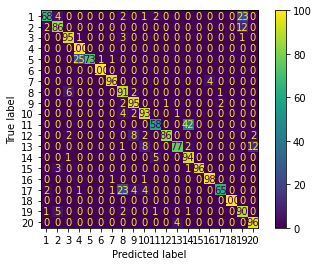

In [22]:
#Predicting the Test set results
y_pred = model_xgb_2.predict(X_test)
 
#Making the Confusion Matrix
cm = confusion_matrix(Y_test, y_pred)
disp = ConfusionMatrixDisplay(cm,display_labels=['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20'])

#Accuracy
from sklearn.metrics import accuracy_score
print("Testing accuracy:")
print(accuracy_score(Y_test, y_pred))
#F1_score
from sklearn.metrics import f1_score
print("Testing F1-score")
print(f1_score(Y_test, y_pred, average = 'macro'))
#Precision
from sklearn.metrics import precision_score
print("Testing Precision:")
print(precision_score(Y_test, y_pred, average = 'macro'))
#Recall
from sklearn.metrics import recall_score
print("Testing Recall:")
print(recall_score(Y_test, y_pred, average = 'macro'))

disp.plot()